# Taking User Inputs for Maximum Camber,Position of Maximum Camber


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.integrate import trapezoid
import sympy as sp
c= np.linspace(0,1,1000) #c is the cord length which is 1 metre and is divided into 1000 parts which now represents the x co ordinates of the camber points
#Taking maximum camber user input "in metres" and storing it in "m"
m= float(input("Maximum camber :"))
#Taking  Position of maximum camber user input "in metres" and storing it in "p"
p=float( input("Position of Maximum Camber:"))



Maximum camber :0.078
Position of Maximum Camber:0.505


# CAMBER LINE FUNCTION

In [16]:
#This function gives the height (i.e y co ordinates) of the points of camberline for all values of X
#The function take the 2 inputs M,P and a default input 1000
def camber_line(m,p, pointCount = 1000):
  y=[]
  dx = 1/pointCount #lenth of per division
  for i in range(pointCount):
    xVal = i*dx #values of x of the cord points
    if xVal < p :
      y.append((m/p**2)*((2*p*xVal)-xVal**2))
    else:
      y.append((m/(1-p)**2)*(1-2*p+2*p*xVal-xVal**2))
  return y #we got the y co ordinates of the points on the camber line

 #converting y into an array for ease in computation
y=np.array(camber_line(m,p))



# Plot camber line

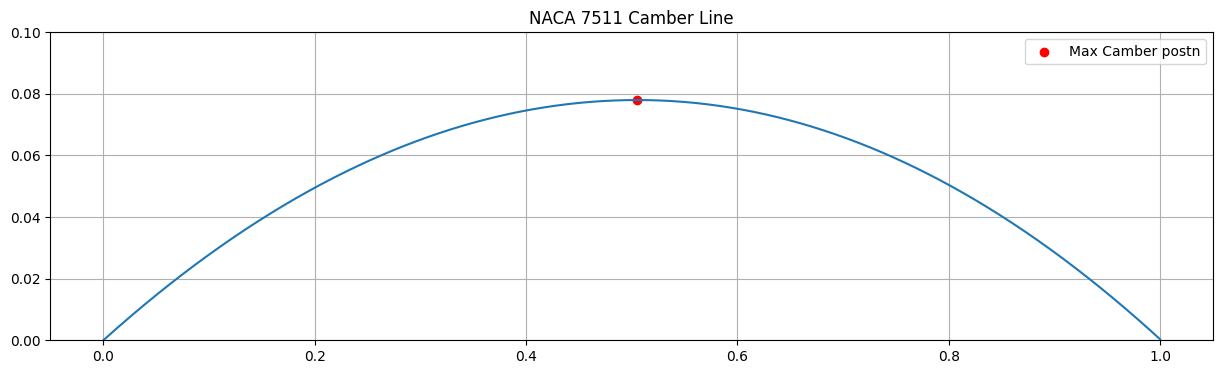

In [17]:
def Plot_camberline(c,y): #function takes inputs cord line x co ordinate,ya cordinate arrays
  plt.figure(figsize=(15, 4)) #Sclaes the size of the graph
  plt.plot(c,y)
  plt.grid()
  plt.scatter([p],[m],color='r',label='Max Camber postn')
  plt.title(f'NACA {int(m*100)}{int(p*10)}11 Camber Line')
  plt.ylim(0,0.1)
  plt.legend()
  plt.show()
Plot_camberline(c,y)


# Calculating slope at points

In [19]:
#calculates slope at each point on the camber line
#takes the same inputs as camber line
def Camber_slope(m,p):
  s=[]
  for i in range(len(c)):
    if c[i] < p :
      s.append((2*m/p**2)*((p)-c[i]))
    else:
      s.append((2*m/(1-p)**2)*(p-c[i]))
  return s

s=np.array(Camber_slope(m,p))



# Plotting the Camber slope

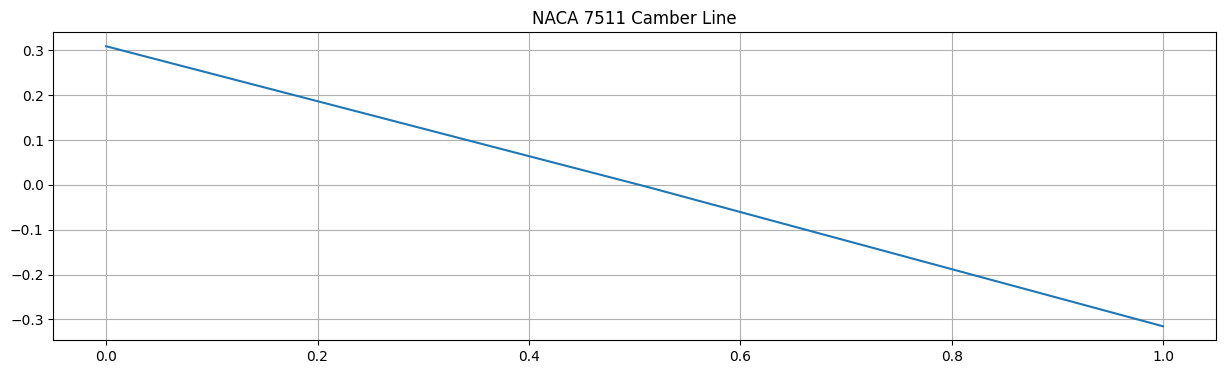

In [20]:
#Plots camber line taking the inputs a the x co ordinates of the camber points and slope at each point
def Plot_camber_slope(c,s):
  plt.figure(figsize=(15, 4)) #scales the size of the graph
  plt.plot(c,s)
  plt.grid()
  plt.title(f'NACA {int(m*100)}{int(p*10)}11 Camber Line')


  plt.show()
Plot_camber_slope(c,s)


# Computing theta

In [21]:
#This function finds the value of theta for for each point by taking x cordinates as input
def theta(c):
  theta=[]

  for i in range(len(c)):
    theta.append(np.arccos(1-2*c[i]))
  return theta

theta=np.array(theta(c))


# Computing coefficients(AOA input is taken here)

In [22]:
alpha=int(input("Enter value for AOA:")) #takes angle of attack input from user and stores in alpha
alpha*=np.pi/180 #converting to radian
#this func computes coeefients A0,1,2,...n by taking AOA ,slopes at each point,x cordinates ,theta at each point
def compute_coef(alpha,s,theta,c):
  A=np.zeros_like(c)

  theta=theta[1:len(theta)] #removing the zero value from theta
  s=s[:len(theta)] #ensuring that both have same lenghts for integration

  A[0]=alpha-((1/np.pi)*trapezoid(s,theta))
  for i in range(1,len(c)):
    A[i]=((2/np.pi) * trapezoid(s*np.cos(i*theta), theta))
  return A
A=compute_coef(alpha,s,theta,c) #storing the array in A






Enter value for AOA:3


# Computing Cl

In [23]:
def compute_cl(A): #Computing Cl by taking the array of co efficients as input
    return np.pi * (2 * A[0] + A[1])
Cl=compute_cl(A)
print(Cl)

1.3105651543969308


# Computing Cm

In [24]:
def compute_cm(A):#Computes Cm by taking the array of co efficients
  return -np.pi / 2 * (A[0] + A[1] - A[2] / 2)
Cm = compute_cm(A)
print(Cm)


-0.574718611084527


# Calculating circulation density (Gamma)
   (User input for free stream velocity is taken here)

In [27]:

U_fs=float(input("Enter value for free stream velocity:"))
def gamma(A, theta): #calculates the gamma values by taking coeefients array and theta array as input
    sum = 0
    theta=theta[1:len(theta)] #removing the zero value from theta for not getting infinity

    for i in range(len(A)):
        sum = sum + (A[i]*np.sin(i*theta))  #Calculating the summation of co efficients
    if np.any(np.sin(theta)!= 0):
       gamma = 2* U_fs * (A[0]*(1+np.cos(theta))/np.sin(theta)+sum) #substituting the summation in gamma formula with ensuring that sin(theta value doesnt get 0)

    return gamma
gamma=np.array(gamma(A,theta)) #converting to array for easy computation in upcoming steps
gamma=np.append(gamma,1.1151244138455652e-11) #As we removed the 0 value from theta the len of gamma array was 999 which was causing error in integration in the upcoming steps so duplicated the last value to get 1000 values




Enter value for free stream velocity:20


# Calculating Bound Circulation (By integrating vortex filaments)

In [28]:
def compute_bound_circulation(gamma): #This function calculates bound circulation by taking gamma array as input
    print("Calculating")

    num_points = 1000
    points = np.linspace(0.0001, 0.9999, num_points)

    # Vectorized camber line computation
    y = camber_line(m,p)  # Computing y co ordinate values of camber line points
    y_next = np.roll(y, -1)  # Shift y values to calculate differences
    y_diff = y_next - y  # Vectorized y differences

    # Calculate ds (integration elements) using vectorized operations
    dx = points[1] - points[0]  # Constant step size in x-direction
    ds = np.sqrt(dx**2 + y_diff[:]**2)  # Exclude last point to match dimensions

    # Compute circulation using vectorized sum
    circulation = np.sum(gamma[:] * ds)  # Sum gamma * ds

    print("Bound circulation = ")
    return circulation
compute_bound_circulation(gamma)


Calculating
Bound circulation = 


13.180172226333662

# Computing Velocities

In [29]:
import numpy as np
#This funtion computes x,y component of velocities at all points bybtaking x, y co ordinates , gamma array as input
def compute_velocity(xi, yi, gamma):#Due to multiple use of x,y this the variable is named as xi,y1 to avoid misplacemnet
    # Ensure xi and yi are flattened to 1D arrays
    xi = np.asarray(xi).flatten()
    yi = np.asarray(yi).flatten()

    # Generate vortex element positions along the camber line
    vortex_points = np.linspace(0.005, 0.995, len(gamma))  # Adjust vortex points to match gamma length
    h = np.array(y)  # Camber line heights(y -cordinates)(variable name changed to avoid confusion)

    # Broadcast vortex points and circle points to compute distances
    dx = xi[:, None] - vortex_points  # x component of distance from vortex filament
    dy = yi[:, None] - h[None, :]     # y component of distance from vortex filament
    r = np.sqrt(dx**2 + dy**2) + 1e-6  # Avoid division by zero

    # Compute induced velocity strength
    v_ind = gamma[None, :] * 0.001 / (2 * np.pi * r)

    # Compute induced velocity components
    sint = dy / r
    cost = dx / r
    vel_x_ind = np.sum(v_ind * sint, axis=1)
    vel_y_ind = np.sum(-v_ind * cost, axis=1)

    # Add free-stream velocity components to get absolute velocities at the aat the points
    #  U_fs and alpha are defined are defined above
    vel_x = vel_x_ind + U_fs* np.cos(alpha)
    vel_y = vel_y_ind + U_fs* np.sin(alpha)

    return vel_x, vel_y





# Computing Circulation by line integral method

In [30]:
def compute_circulation(gamma): #Computes circulation taking previously obtained gamma array as input
    # Define angles and precompute trigonometric values
    theta = np.linspace(0, 2 * np.pi, 1000) #this the local variable theta not the global one .
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)

    # Parametric coordinates and tangential unit vectors
    circle_coords = np.stack((2 * cos_theta, 2 * sin_theta))
    tangents = np.stack((-2 * sin_theta, 2 * cos_theta))

    # Compute velocity vectors by calling the velocity function
    velocity = compute_velocity( circle_coords[0], circle_coords[1], gamma)

    # Compute circulation using vectorized dot product
    circulation = np.sum(tangents[0] * velocity[0] + tangents[1] * velocity[1])  # Element-wise dot product

    # Apply integration factor
    circulation *= -2 * np.pi / 1000  # Precomputed factor for efficiency

    print("Line integral circulation:", circulation)
    return circulation
circulation= compute_circulation(gamma)
print(circulation)

Line integral circulation: 12.970615248674472
12.970615248674472


# Plotting velocity field

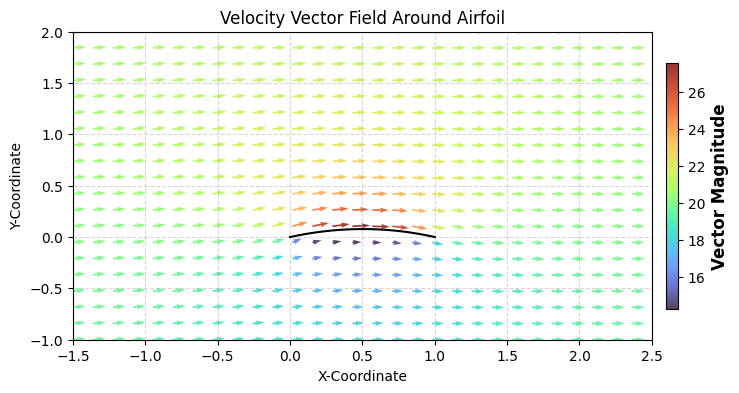

In [31]:

        fig ,ax = plt.subplots(figsize=(9, 4)) #for scaling both the plots to same size in the same area
        # setting the x ,y cordinates values  for vector field
        x_cdn, y_cdn = np.meshgrid(np.linspace(-1.5, 2.5, 30), np.linspace(-1, 2, 20))


        c1, d1 = compute_velocity(x_cdn, y_cdn, gamma) #c1,d1 are x and y compoments of velocities

        magnitude = np.sqrt(c1**2 + d1**2) #resultant mangnitude of the velocities

        q = ax.quiver(x_cdn, y_cdn, c1, d1, magnitude, cmap='turbo', scale=900, width=0.003, edgecolors='k', alpha=0.8)
        #adding a colour bar to show velocity magnitude
        cb = plt.colorbar(q, ax=ax, shrink=0.8, aspect=20, pad=0.02)
        cb.set_label("Vector Magnitude", fontsize=12, weight='bold')

        # Plot camber line
        x_coords = np.linspace(0, 1, 1000)
        y_coords = np.array(camber_line(m, p, 1000))

        ax.plot(x_coords, y_coords, color="black", linewidth=1.5)

        ax.set_xlabel("X-Coordinate")
        ax.set_ylabel("Y-Coordinate")
        ax.set_title("Velocity Vector Field Around Airfoil")
        ax.set_xlim(-1.5, 2.5)
        ax.set_ylim(-1, 2)
        ax.grid(True, linestyle="--", alpha=0.5)










